# Workload Characterization

## Introduction

### Import relevant modules

In [1]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Utilities
import numpy as np
# import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'

#### Low level parameters

In [3]:
df_low = pd.read_csv('WC_report_server.csv', sep='\s+', skiprows=1)
df_low.rename(columns={'r':'procs_r', 'b':'procs_b',
                       'swpd':'memory_swpd', 'free':'memory_free', 'buff':'memory_buff', 'cache':'memory_cache', 
                       'si':'swap_si', 'so':'swap_so', 
                       'bi':'io_bi', 'bo':'io_bo',
                       'in':'system_in', 'cs':'system_cs',
                       'us':'cpu_us', 'sy':'cpu_sy', 'id':'cpu_id', 'wa':'cpu_wa', 'st':'cpu_st'
                      }, inplace=True)
df_low.head()

procs_r  procs_b  memory_swpd  memory_free  memory_buff  memory_cache  \
0        5        0       367104       148460        42008        898668   
1        1        0       367104       150476        42016        898636   
2        2        0       367104       150700        42016        898636   
3        2        0       367104       146948        42024        898628   
4        1        0       367104       147704        42024        898636   

   swap_si  swap_so  io_bi  io_bo  system_in  system_cs  cpu_us  cpu_sy  \
0       10      101    894   2866       1623       1345      25      13   
1       40        0     60      0        456        895      85      15   
2        0        0      0      0        447        734      84      16   
3        0        0      0    124        430        751      83      17   
4        0        0      0      0        413        694      81      19   

   cpu_id  cpu_wa  cpu_st  
0      53       9       0  
1       0       0       0  
2       0       0       0  
3       0       0       0  
4       0       0       0

In [4]:
print('The dataset contains', df_low.shape[1], 'columns and', df_low.shape[0], 'rows')

The dataset contains 17 columns and 315 rows


# High level parameters

## Read data

In [5]:
df_high = pd.read_csv('WC_report_client.csv')
df_high.head()

timeStamp  elapsed                           label  responseCode  \
0  1609320468373      109  HTTP Request - Repubblica Home           200   
1  1609320468373      109  HTTP Request - Repubblica Home           200   
2  1609320468374      125      HTTP Request - Reddit Home           200   
3  1609320468662       11      HTTP Request - Reddit Home           200   
4  1609320468682        6  HTTP Request - Repubblica Home           200   

  responseMessage               threadName dataType  success  failureMessage  \
0              OK  Thread Group - Fast 2-1     text     True             NaN   
1              OK  Thread Group - Slow 1-1     text     True             NaN   
2              OK  Thread Group - Home 3-1     text     True             NaN   
3              OK  Thread Group - Slow 1-2     text     True             NaN   
4              OK  Thread Group - Fast 2-2     text     True             NaN   

    bytes  sentBytes  grpThreads  allThreads  \
0  387753        135           1           3   
1  387753        135           1           3   
2  911062        131           1           3   
3  911062        131           2           4   
4  387753        135           2           5   

                                         URL  Latency  IdleTime  Connect  
0  http://192.168.56.101/RepubblicaHome.html       58         0       32  
1  http://192.168.56.101/RepubblicaHome.html       58         0       32  
2      http://192.168.56.101/RedditHome.html       92         0       32  
3      http://192.168.56.101/RedditHome.html        3         0        1  
4  http://192.168.56.101/RepubblicaHome.html        2         0        1

In [6]:
print('The dataset contains', df_high.shape[1], 'columns and', df_high.shape[0], 'rows')

The dataset contains 17 columns and 40416 rows


In [7]:
df_high['success'].all()

True

In [12]:
df_high.loc[df_high['label'].str.contains('Wikipedia'), 'resourceType'] = 'small'
df_high.loc[df_high['label'].str.contains('Repubblica'), 'resourceType'] = 'medium'
df_high.loc[df_high['label'].str.contains('Reddit'), 'resourceType'] = 'large'

df_high.loc[df_high['threadName'].str.contains('Slow'), 'threadType'] = 'slow'
df_high.loc[df_high['threadName'].str.contains('Fast'), 'threadType'] = 'fast'
df_high.loc[df_high['threadName'].str.contains('Home'), 'threadType'] = 'home'

df_high.head()

timeStamp  elapsed                           label  responseCode  \
0  1609320468373      109  HTTP Request - Repubblica Home           200   
1  1609320468373      109  HTTP Request - Repubblica Home           200   
2  1609320468374      125      HTTP Request - Reddit Home           200   
3  1609320468662       11      HTTP Request - Reddit Home           200   
4  1609320468682        6  HTTP Request - Repubblica Home           200   

  responseMessage               threadName dataType  success  failureMessage  \
0              OK  Thread Group - Fast 2-1     text     True             NaN   
1              OK  Thread Group - Slow 1-1     text     True             NaN   
2              OK  Thread Group - Home 3-1     text     True             NaN   
3              OK  Thread Group - Slow 1-2     text     True             NaN   
4              OK  Thread Group - Fast 2-2     text     True             NaN   

    bytes  sentBytes  grpThreads  allThreads  \
0  387753        135           1           3   
1  387753        135           1           3   
2  911062        131           1           3   
3  911062        131           2           4   
4  387753        135           2           5   

                                         URL  Latency  IdleTime  Connect  \
0  http://192.168.56.101/RepubblicaHome.html       58         0       32   
1  http://192.168.56.101/RepubblicaHome.html       58         0       32   
2      http://192.168.56.101/RedditHome.html       92         0       32   
3      http://192.168.56.101/RedditHome.html        3         0        1   
4  http://192.168.56.101/RepubblicaHome.html        2         0        1   

  resourceType threadType  
0       medium       fast  
1       medium       slow  
2        large       home  
3        large       slow  
4       medium       fast

## Data analysis

In [13]:
df_high.describe()

timeStamp       elapsed  responseCode  failureMessage  \
count  4.041600e+04  40416.000000       40416.0             0.0   
mean   1.609321e+12     10.899273         200.0             NaN   
std    8.349091e+04     18.892921           0.0             NaN   
min    1.609320e+12      0.000000         200.0             NaN   
25%    1.609321e+12      3.000000         200.0             NaN   
50%    1.609321e+12      6.000000         200.0             NaN   
75%    1.609321e+12     11.000000         200.0             NaN   
max    1.609321e+12    575.000000         200.0             NaN   

               bytes     sentBytes    grpThreads    allThreads       Latency  \
count   40416.000000  40416.000000  40416.000000  40416.000000  40416.000000   
mean   453445.221002    133.329028     47.048372    127.944898      5.037609   
std    331257.134464      1.708763      7.498846     11.227800     12.355871   
min     78455.000000    131.000000      1.000000      1.000000      0.000000   
25%     93219.000000    131.000000     50.000000    130.000000      1.000000   
50%    387752.000000    134.000000     50.000000    130.000000      1.000000   
75%    857514.000000    135.000000     50.000000    130.000000      4.000000   
max    911062.000000    135.000000     50.000000    130.000000    390.000000   

       IdleTime       Connect  
count   40416.0  40416.000000  
mean        0.0      0.023308  
std         0.0      0.380004  
min         0.0      0.000000  
25%         0.0      0.000000  
50%         0.0      0.000000  
75%         0.0      0.000000  
max         0.0     32.000000

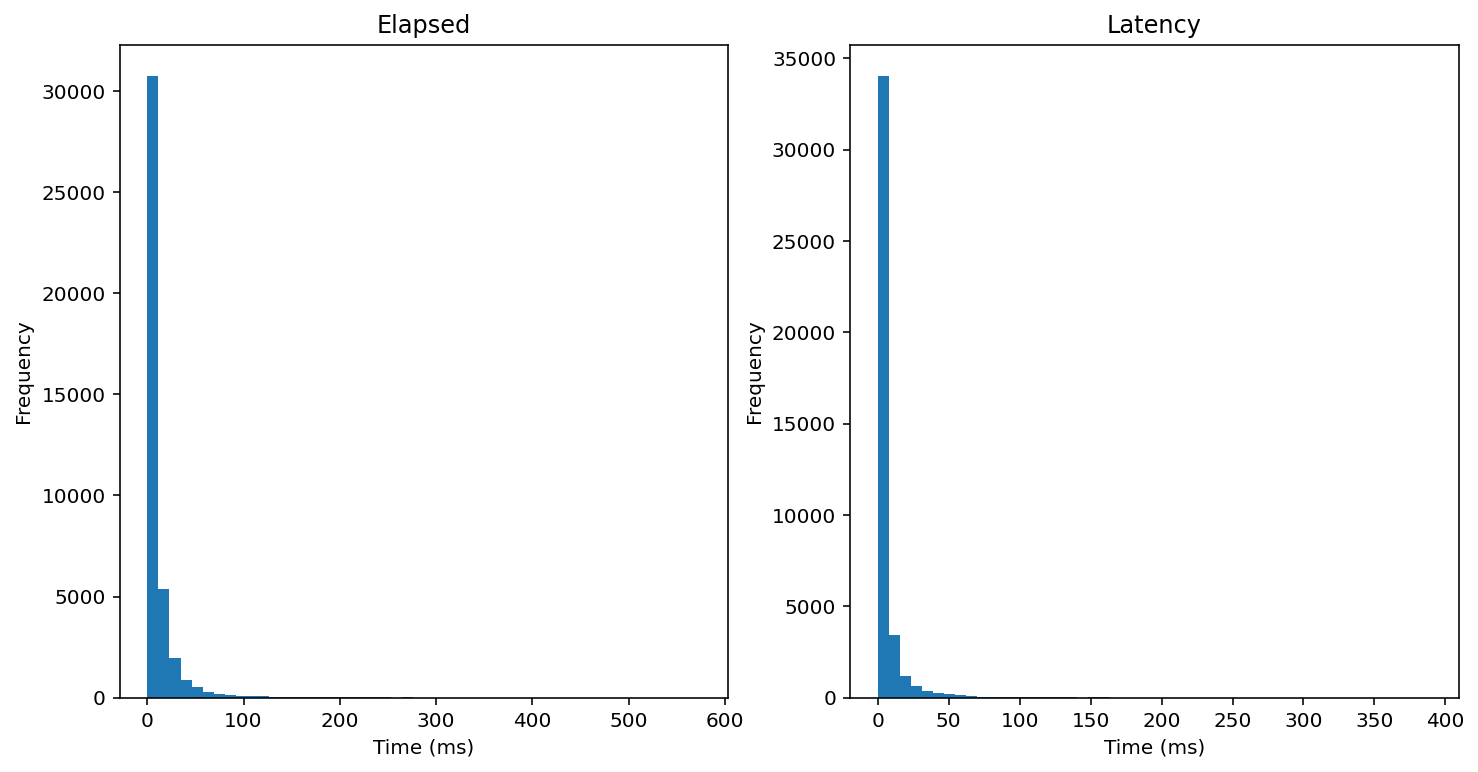

In [15]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.elapsed.plot.hist(bins=50, ax=ax0)
df_high.Latency.plot.hist(bins=50, ax=ax1)

ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed), 5))

ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')
# ax1.set_xticks(np.arange(0, max(df_high.Latency), 5))

plt.show()

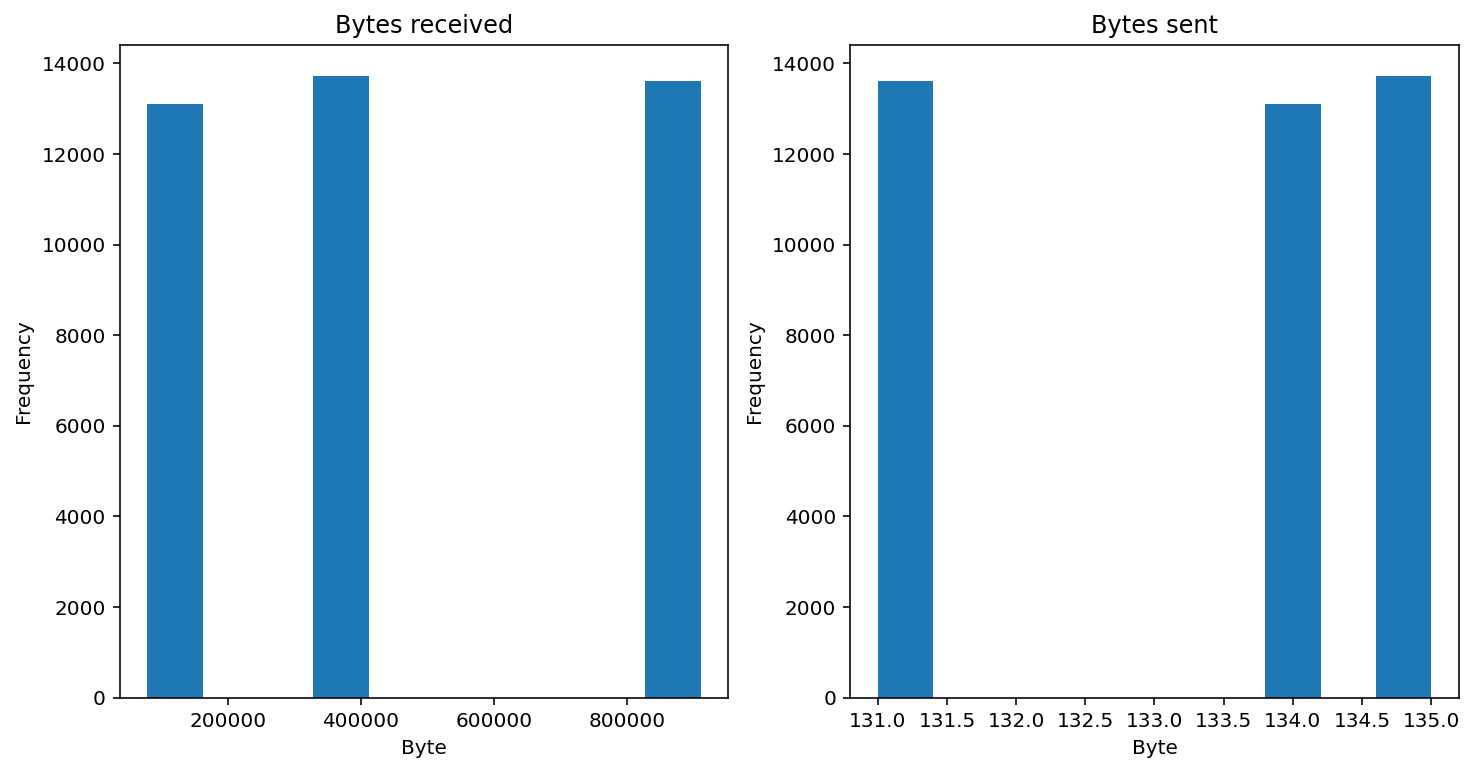

In [16]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.bytes.plot.hist(ax=ax0)
df_high.sentBytes.plot.hist(ax=ax1)

ax0.set_title('Bytes received')
ax0.set_xlabel('Byte')

ax1.set_title('Bytes sent')
ax1.set_xlabel('Byte')

plt.show()

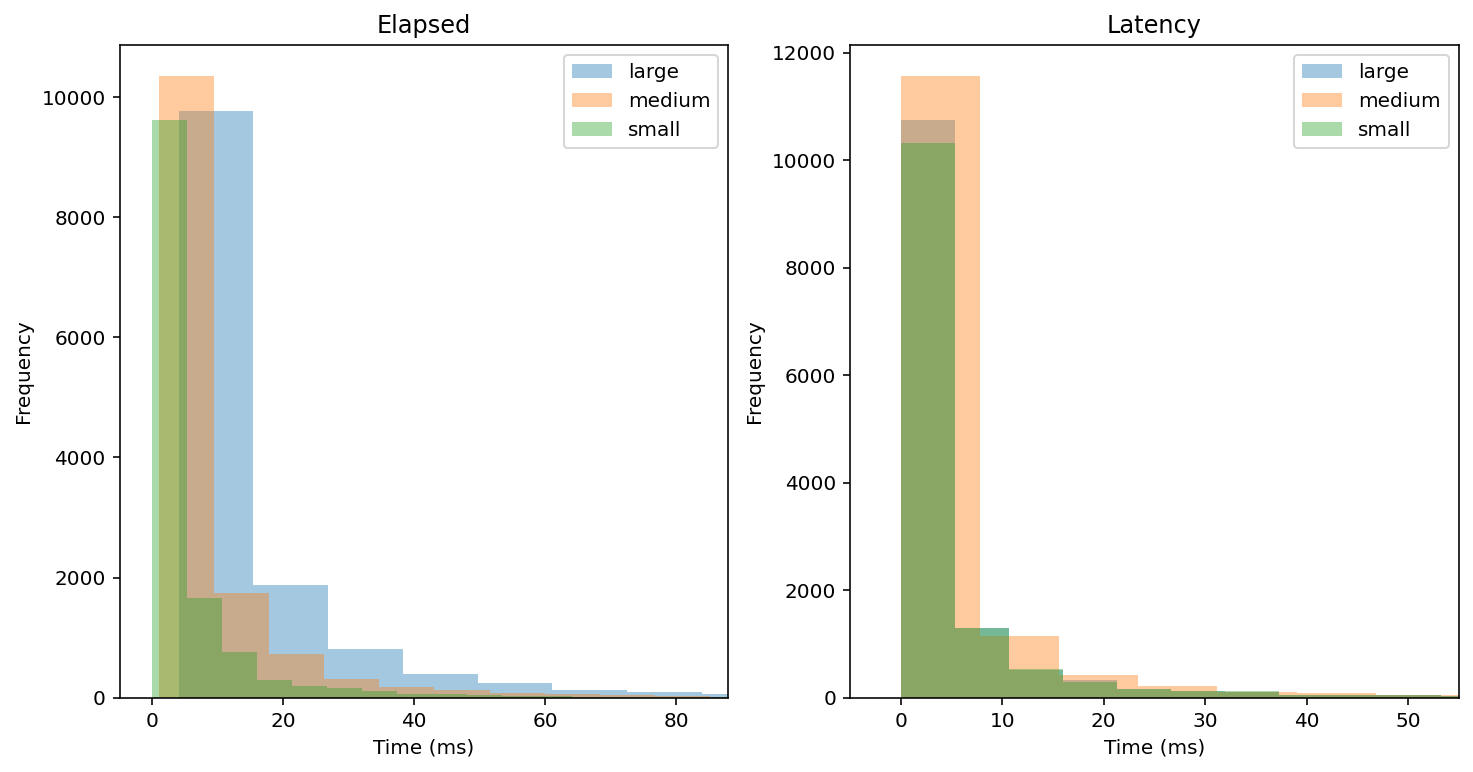

In [17]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.groupby(by='resourceType').elapsed.plot.hist(bins=50, alpha=0.4, legend=True, ax=ax0)
df_high.groupby(by='resourceType').Latency.plot.hist(bins=50, alpha=0.4, legend=True, ax=ax1)

x_max = df_high.quantile(q=0.99).elapsed
ax0.set_xlim(-5,x_max)
ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed)+1, 5))

x_max = df_high.quantile(q=0.99).Latency
ax1.set_xlim(-5,x_max)
ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')
# ax1.set_xticks(np.arange(0, max(df_high.Latency)+1, 5))

plt.show()

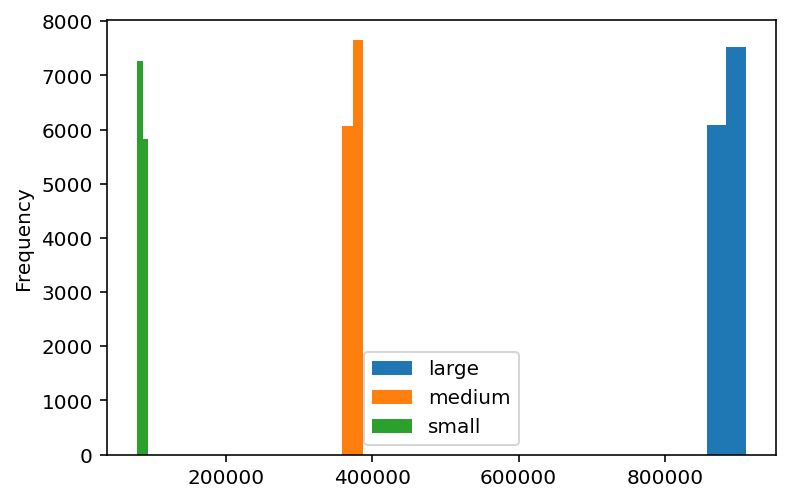

In [18]:
df_high.groupby(by='resourceType').bytes.plot.hist(bins=2, alpha=1, legend=True)

plt.show()

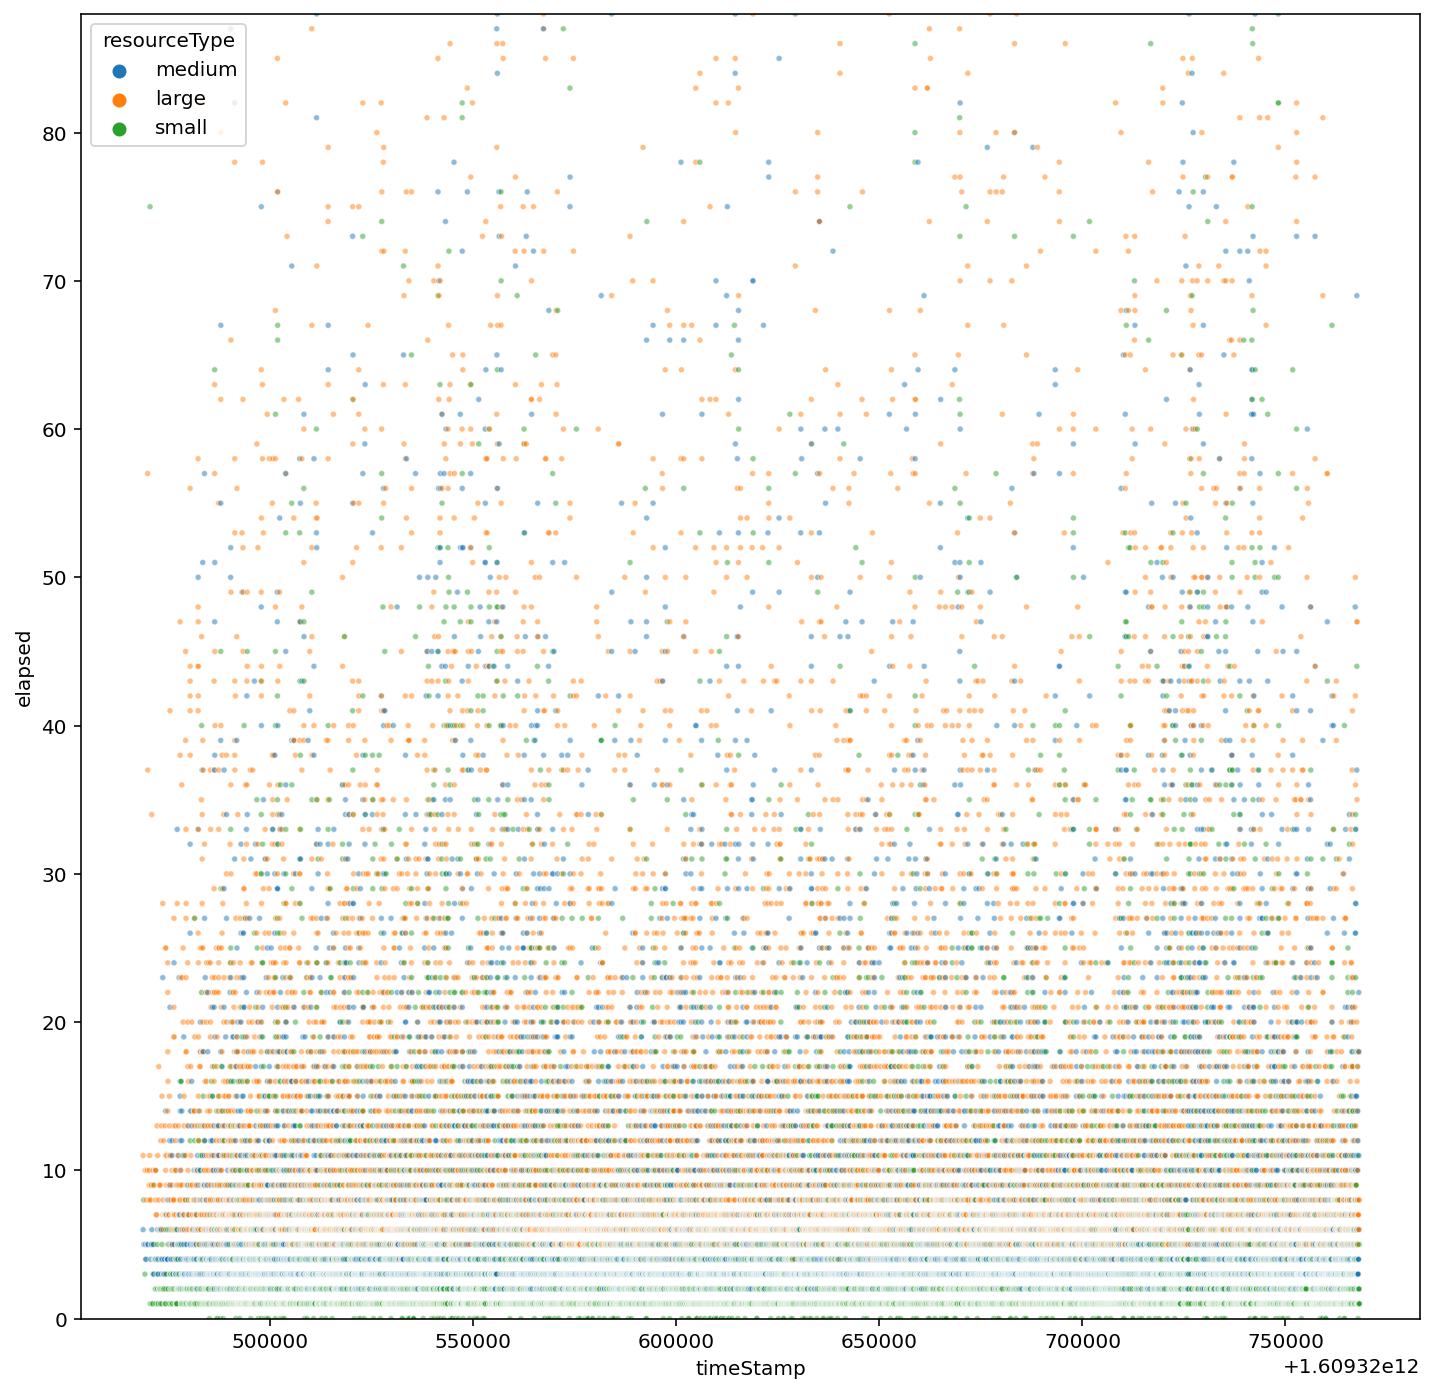

In [20]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='timeStamp', y='elapsed', hue='resourceType', data=df_high, marker='.', alpha=.5)
y_max = df_high.quantile(q=0.99).elapsed
plt.ylim(0,y_max)
plt.show()

c:\users\guido di chiara\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


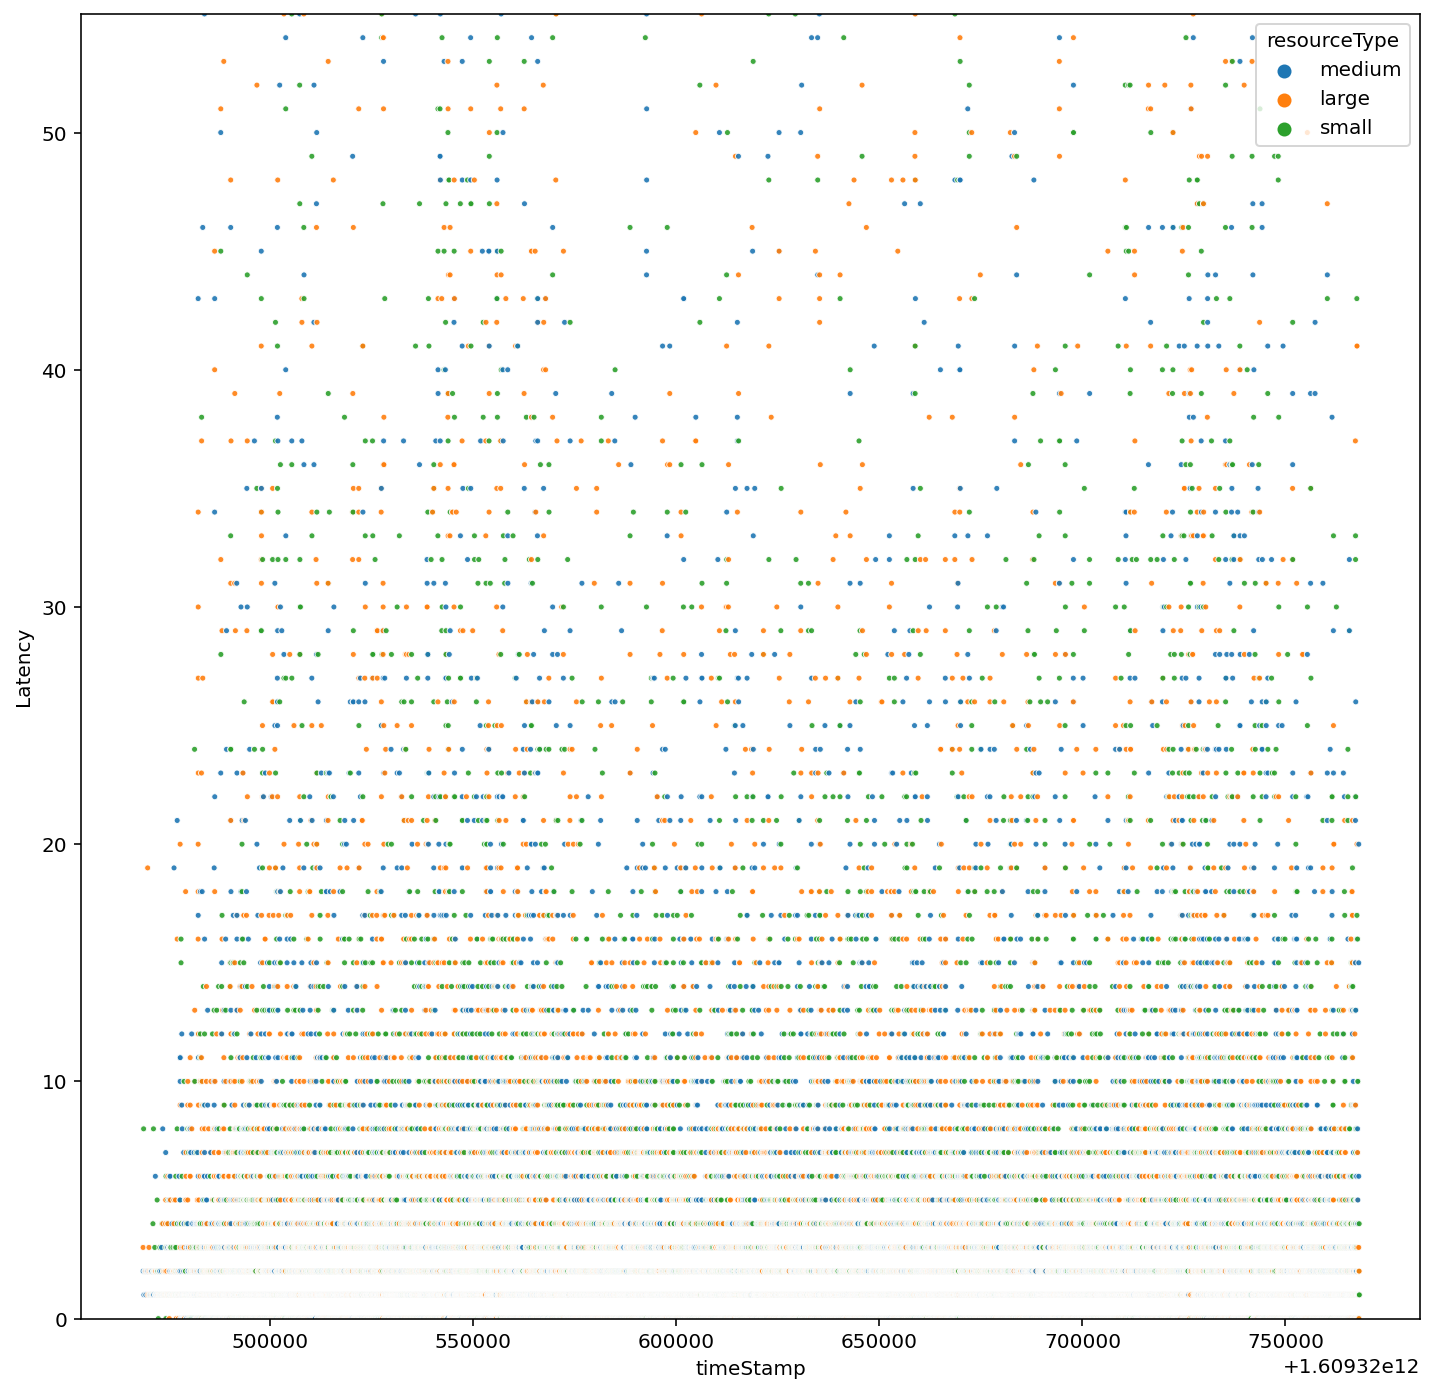

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='timeStamp', y='Latency', hue='resourceType', data=df_high, marker='.', alpha=.9)
y_max = df_high.quantile(q=0.99).Latency
plt.ylim(0,y_max)
plt.show()

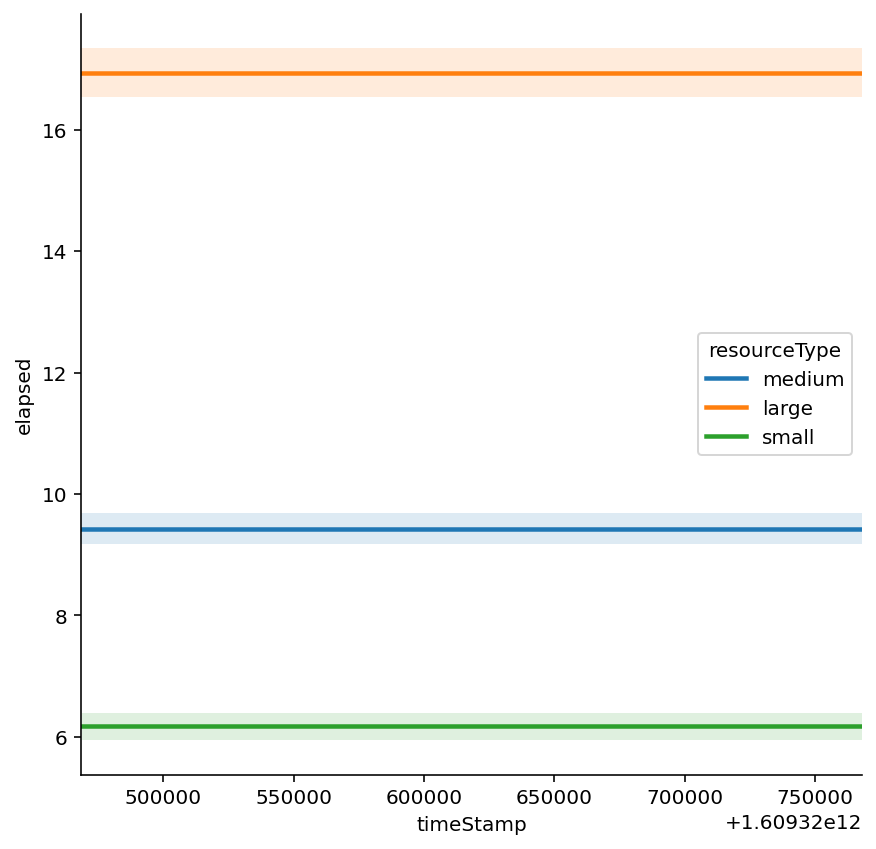

In [22]:
sns.lmplot(x='timeStamp', y='elapsed', hue='resourceType', data=df_high, markers='.', legend_out=False, scatter=False, height=6)
plt.show()

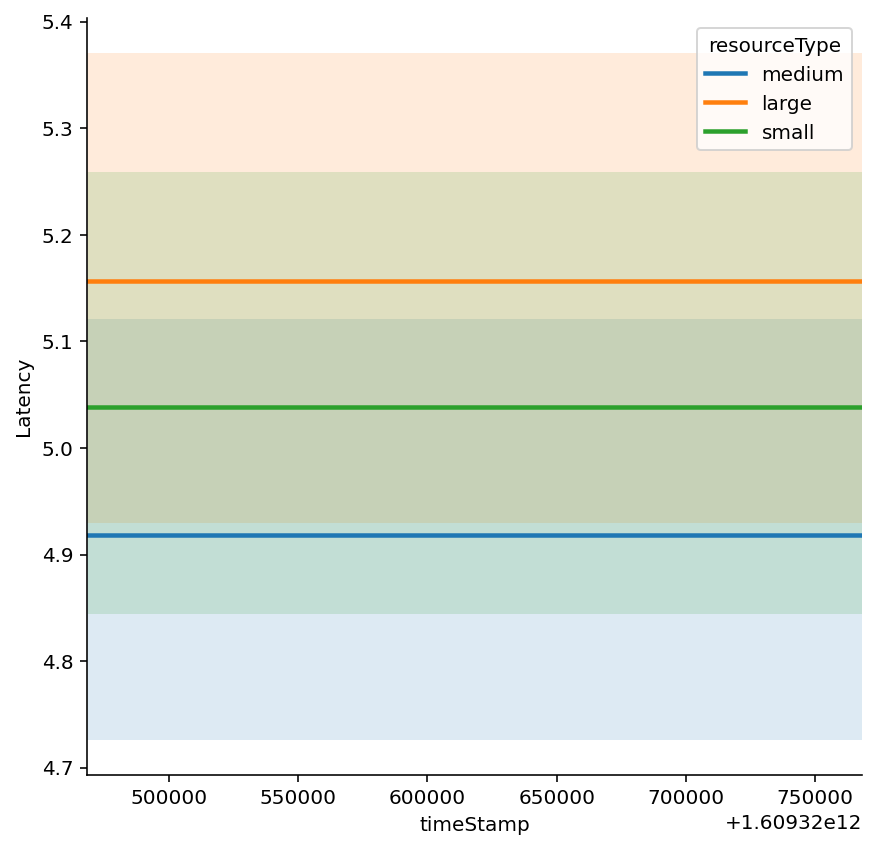

In [23]:
sns.lmplot(x='timeStamp', y='Latency', hue='resourceType', data=df_high, markers='.', legend_out=False, scatter=False, height=6)
plt.show()

## PCA

### Preprocessing

#### Remove nominal columns

In [30]:
df_high.threadType.astype('category').cat.codes

0        0
1        2
2        1
3        2
4        0
        ..
40411    0
40412    0
40413    0
40414    0
40415    0
Length: 40416, dtype: int8

In [24]:
df_high_pre = df_high.select_dtypes(include=['int64']).copy().drop(columns='responseCode')
df_high_pre.head()

timeStamp  elapsed   bytes  sentBytes  grpThreads  allThreads  Latency  \
0  1609320468373      109  387753        135           1           3       58   
1  1609320468373      109  387753        135           1           3       58   
2  1609320468374      125  911062        131           1           3       92   
3  1609320468662       11  911062        131           2           4        3   
4  1609320468682        6  387753        135           2           5        2   

   IdleTime  Connect  
0         0       32  
1         0       32  
2         0       32  
3         0        1  
4         0        1

#### Remove constant components

In [40]:
df_const = df_high_pre.loc[:,df_high_pre.columns[df_high_pre.nunique() == 1]]
df_const.head()

IdleTime
0         0
1         0
2         0
3         0
4         0

In [42]:
df_high_pre = df_high_pre.loc[:,df_high_pre.columns[df_high_pre.nunique() != 1]]
df_high_pre.head()

timeStamp  elapsed   bytes  sentBytes  grpThreads  allThreads  Latency  \
0  1609320468373      109  387753        135           1           3       58   
1  1609320468373      109  387753        135           1           3       58   
2  1609320468374      125  911062        131           1           3       92   
3  1609320468662       11  911062        131           2           4        3   
4  1609320468682        6  387753        135           2           5        2   

   Connect  
0       32  
1       32  
2       32  
3        1  
4        1

#### Remove perfectly correlated components

In [44]:
df_corr = df_high_pre.corr()
df_corr

timeStamp   elapsed     bytes  sentBytes  grpThreads  allThreads  \
timeStamp    1.000000  0.008781 -0.011382   0.012602    0.153374    0.232065   
elapsed      0.008781  1.000000  0.239202  -0.204439   -0.066295    0.016430   
bytes       -0.011382  0.239202  1.000000  -0.821159   -0.009021   -0.008859   
sentBytes    0.012602 -0.204439 -0.821159   1.000000   -0.006556    0.003219   
grpThreads   0.153374 -0.066295 -0.009021  -0.006556    1.000000    0.572790   
allThreads   0.232065  0.016430 -0.008859   0.003219    0.572790    1.000000   
Latency      0.009202  0.758963  0.005413  -0.007620   -0.044340    0.021191   
Connect     -0.026778  0.079202  0.005892  -0.005409   -0.082885   -0.114908   

             Latency   Connect  
timeStamp   0.009202 -0.026778  
elapsed     0.758963  0.079202  
bytes       0.005413  0.005892  
sentBytes  -0.007620 -0.005409  
grpThreads -0.044340 -0.082885  
allThreads  0.021191 -0.114908  
Latency     1.000000  0.060764  
Connect     0.060764  1.000000

#### Normalize the components

In [57]:
x = df_high_pre.values

x_scaled = StandardScaler().fit_transform(x)

df_high_pre = pd.DataFrame(data=x_scaled, columns=df_high_pre.columns )
df_high_pre.head()

timeStamp   elapsed     bytes  sentBytes  grpThreads  allThreads   Latency  \
0  -1.860421  5.192524 -0.198314   0.977896   -6.140803  -11.128310  4.286468   
1  -1.860421  5.192524 -0.198314   0.977896   -6.140803  -11.128310  4.286468   
2  -1.860409  6.039412  1.381472  -1.363008   -6.140803  -11.128310  7.038230   
3  -1.856959  0.005332  1.381472  -1.363008   -6.007448  -11.039244 -0.164912   
4  -1.856720 -0.259321 -0.198314   0.977896   -6.007448  -10.950179 -0.245846   

     Connect  
0  84.149379  
1  84.149379  
2  84.149379  
3   2.570249  
4   2.570249

### Perform PCA

In [63]:
pca = PCA()

princ_comp = pca.fit(df_high_pre.values)

In [64]:
d = pca.transform(df_high_pre.values)

c = [str(s) for s in range(princ_comp.n_components_)]
c = ['comp ' + s for s in c]

df_high_pca = pd.DataFrame(data=d, columns=c)
df_high_pca.head()

comp 0     comp 1    comp 2     comp 3     comp 4    comp 5    comp 6  \
0  11.945818  28.588272  8.566314  76.719991  19.301046 -0.136139 -0.248441   
1  11.945818  28.588272  8.566314  76.719991  19.301046 -0.136139 -0.248441   
2  15.527245  28.179244  8.910607  76.444931  19.307926  0.086874 -1.980111   
3   2.862623  11.477028 -3.651481   1.152430  -2.166520  3.538410 -0.092061   
4   0.619602  12.014584 -2.108541   1.110710  -2.108700  3.464732  0.348154   

     comp 7  
0 -0.719980  
1 -0.719980  
2 -0.888473  
3 -0.038486  
4 -0.432186

#### Explained variance

In [65]:
d = {'explained variance': princ_comp.explained_variance_, 'explained variance ratio': princ_comp.explained_variance_ratio_}

df_variance_PCA = pd.DataFrame(data=d)

df_variance_PCA['cumulative explained variance ratio'] = df_variance_PCA.cumsum()['explained variance ratio']
df_variance_PCA.head(10)

explained variance  explained variance ratio  \
0            2.046019                  0.255746   
1            1.709531                  0.213686   
2            1.580770                  0.197591   
3            0.968810                  0.121098   
4            0.889366                  0.111168   
5            0.416497                  0.052061   
6            0.218990                  0.027373   
7            0.170215                  0.021276   

   cumulative explained variance ratio  
0                             0.255746  
1                             0.469432  
2                             0.667023  
3                             0.788122  
4                             0.899290  
5                             0.951350  
6                             0.978724  
7                             1.000000

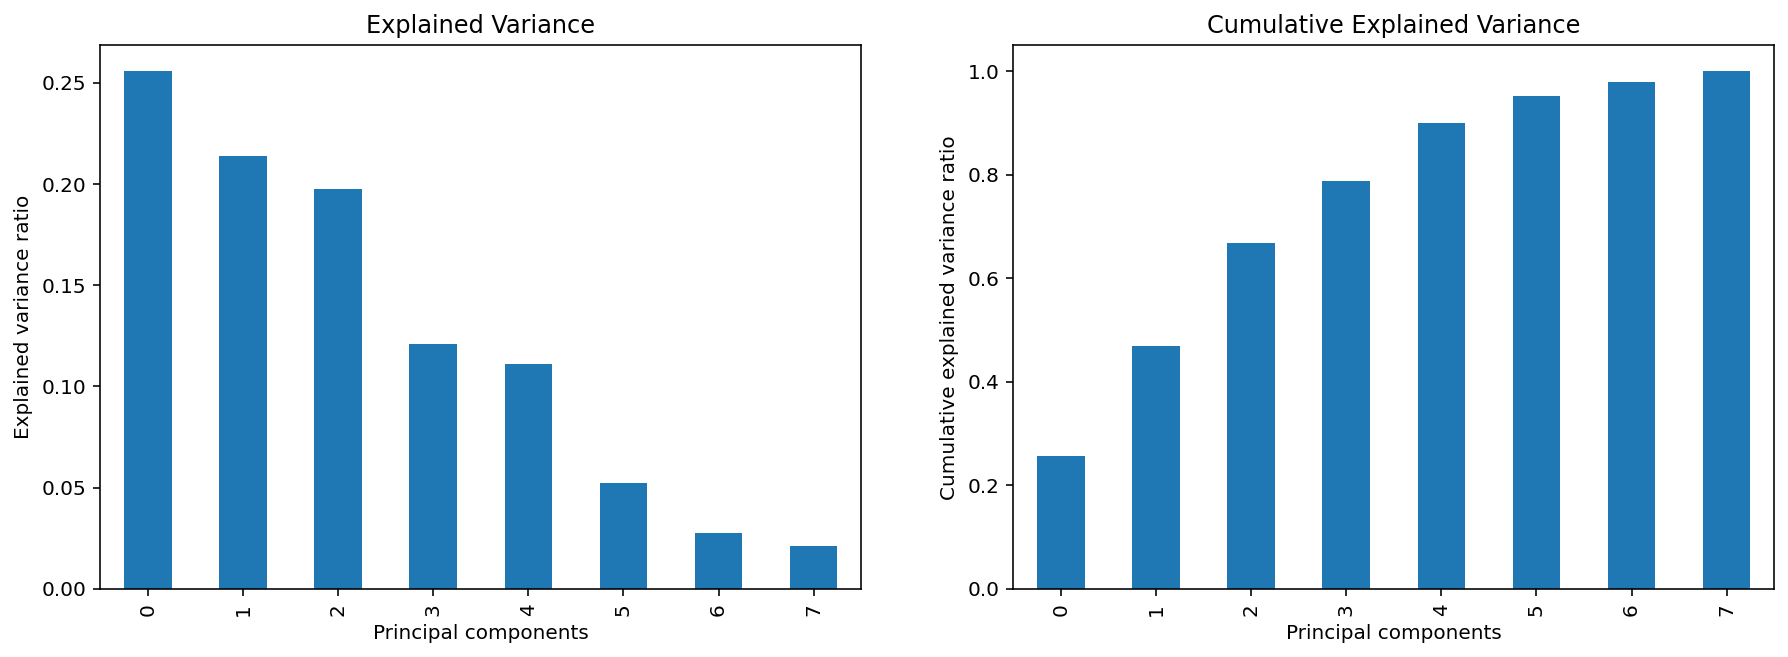

In [66]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

df_variance_PCA.plot.bar(y=['explained variance ratio'], ax=ax0, legend=False)
df_variance_PCA.plot.bar(y=['cumulative explained variance ratio'], ax=ax1, legend=False)

ax0.set_title('Explained Variance')
ax0.set_xlabel('Principal components')
ax0.set_ylabel('Explained variance ratio')

ax1.set_title('Cumulative Explained Variance')
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative explained variance ratio')
plt.show()

## Clustering

### Select principal components

In [69]:
n_comp = 6

df_high_cl = df_princ_comp.iloc[:,0:n_comp]
df_high_cl.head()

comp 0     comp 1    comp 2     comp 3     comp 4    comp 5
0  11.945818  28.588272  8.566314  76.719991  19.301046 -0.136139
1  11.945818  28.588272  8.566314  76.719991  19.301046 -0.136139
2  15.527245  28.179244  8.910607  76.444931  19.307926  0.086874
3   2.862623  11.477028 -3.651481   1.152430  -2.166520  3.538410
4   0.619602  12.014584 -2.108541   1.110710  -2.108700  3.464732

### Perform clustering

In [20]:
n_clusters = 10

clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering = clustering.fit(df_clustering.values)

In [21]:
df_clustered = df_rough
df_clustered.loc[:,'cluster'] = clustering.labels_
df_clustered.head()

VmPeak  VmSize  VmHWM  VmRSS  VmPTE  Threads  MemFree  Buffers  Cached  \
0  144012  126424  14224  14224    108        9  5621452    29064  334600   
1  152272  150216  24508  23708    160        9  5610188    29144  334640   
2  152272  150216  24628  24588    160       15  5609652    29240  334640   
3  152272  150216  24628  24500    160       35  5610232    29336  334640   
4  152272  150216  24628  24580    160       29  5610032    29432  334640   

   Active  ...  Slab  PageTables  Committed_AS  NumOfAllocFH  proc-fd  \
0       0  ...     0       67408         22840         26160     6968   
1       0  ...     0       76172         23700         27792     7192   
2       0  ...     0       76608         23708         27996     7188   
3       0  ...     0       76608         23708         27996     7196   
4       0  ...     0       76792         23708         27948     7196   

   avgThroughput  avgElapsed  avgLatency  Errors  cluster  
0         268820         510           0       2        5  
1         293700         510           0       2        5  
2         293336         510           0       2        5  
3         293336         510           0       2        5  
4         295484        1020           0       2        5  

[5 rows x 25 columns]

### 4.3. Synthetic workload
Clearly, Ward's method is the most appropriate for workload characterization: on one hand it allows to reduce the workload dimension and on the other hand it preserve most of the workload variance.
In this case, we started with a real workload of 3000 observations and now we have a workload of 10 observations, each of which is a random sample of the relative cluster. In the following section we will look at the variance (deviance) lost.

In [22]:
df_synth = df_clustered.groupby('cluster').apply(lambda x: x.sample())
df_synth = df_synth.reset_index(level=0, col_level=2 , drop=True)
df_synth

VmPeak  VmSize  VmHWM  VmRSS  VmPTE  Threads  MemFree  Buffers   Cached  \
90    170344  170340  31144  31140    200       43  4471580    94884  1259568   
1563  172392  170340  33228  32316    200       12  4582560   182436  1117772   
84    153484  151436  26612  26468    160       32  5084564    83540   693480   
901   172392  170340  32696  31516    200       51  4607964   158528  1117364   
2861  215352  211256  61784  58504    316      161  4530200   204244  1118444   
45    152272  150216  25228  25208    160       58  5604588    33440   334672   
91    170344  170340  31148  31140    200       26  4720436    97808  1064968   
2584  194112  184580  43804  35068    252       88  4556012   202556  1118276   
2092  188104  181004  41320  35140    240      101  4562080   195824  1118036   
2761  208184  201016  55500  49484    300      161  4539932   203788  1118364   

      Active  ...  Slab  PageTables  Committed_AS  NumOfAllocFH  proc-fd  \
90         0  ...     0      134504         29956        116216     8024   
1563       0  ...     0       84656         23844        110884     7208   
84         0  ...     0      126116         28324         90284     7984   
901        0  ...     0       83860         23740        110196     7208   
2861       0  ...     0      110848         23848        112884     7324   
45         0  ...     0       77472         23772         27852     7192   
91         0  ...     0       84604         24312        109564     7576   
2584       0  ...     0       87408         23848        113952     7260   
2092       0  ...     0       87492         23848        114636     7248   
2761       0  ...     0      101816         23848        112736     7308   

      avgThroughput  avgElapsed  avgLatency  Errors  cluster  
90           365692        1530           0       2        0  
1563         314744        1020           0       2        1  
84           343200        2040           0       2        2  
901          316328        1530           0       2        3  
2861         352876         510           0       2        4  
45           294280        1530           0       2        5  
91           315392        1530           0       2        6  
2584         330568         510           0       2        7  
2092         328124        1020           0       2        8  
2761         344780        1020           0       2        9  

[10 rows x 25 columns]

## 5. Deviance
As we already said, we want a synthetic workload to be representative of the real one, in term of variability of the data. For this reason, we need to observ how both techniques used in the characterization process affect the worload variance.

Let's start by computing the total deviance of the workload.

In [23]:
dev_tot = df_scaled.sub(df_scaled.mean()).pow(2).sum().sum()
dev_tot

57000.00000000045

### 5.1. Deviance after PCA
Now let's compute the deviance preserved by PCA.

In [24]:
df_pca = df_princ_comp.iloc[:,0:3]
dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()
dev_pca

47951.25674666057

In [25]:
dev_pca_ratio = dev_pca/dev_tot
dev_pca_ratio

0.8412501183624594

As expected, considering just three of the principal components, we are including the 84% of the total deviance.

### 5.2. Deviance after clustering
Now we can see how clustering affects deviance of data. First of all, total deviance of clustered data (deviance after PCA) can be written as:<br>
<center>$d_{PCA} = d_{intra} + d_{inter}$</center>

where $d_{intra}$ and $d_{inter}$ are called respectively *intra-cluster deviance* and *inter-cluster deviance*.
Since we consider just one random point for each cluster, $d_{intra}$ is the amount of deviance lost form PCA deviance, whereas $d_{inter}$ it the amount of deviance preserved.

#### Intra-cluster deviance
Intra-cluster deviance is the sum of the deviance of each cluster:<br>
<center>$d_{intra} = \sum_{k=1}^{K} \sum_{i=1}^{n_k} ||x_i - \overline x_k||$</center>

where:
- $K$ is the number of clusters
- $n_k$ is the number of points of cluster $k$
- $x_i$ is the $i$-th point of cluster $k$
- $\overline x_k$ is the centroid of cluster $k$

In [26]:
df_clustering.loc[:,'cluster'] = clustering.labels_
n_elem = df_clustering.groupby('cluster').count().values[:,0]
centroids = df_clustering.groupby('cluster').mean()

In [27]:
arr = np.zeros(shape=(n_clusters,1))

for i in range(n_clusters):
    elem_i = df_clustering.loc[df_clustering['cluster'] == i].drop(columns='cluster')
    arr[i] = elem_i.sub(centroids.loc[i,:]).pow(2).sum().sum()
    
dev_intra = arr.sum()
dev_intra

993.5895196217946

In [28]:
dev_intra_ratio = dev_intra/dev_pca
dev_intra_ratio

0.020720823332560315

#### Inter-cluster deviance
Inter-cluster deviance is defined as:<br>
<center>$d_{inter} = \sum_{k=1}^{K} n_k ||\overline x_k - \overline x||$</center>

where:
- $K$ is the number of clusters
- $n_k$ is the number of points of cluster $k$
- $\overline x_k$ is the centroid of cluster $k$
- $\overline x_ = \frac{1}{n} \sum_{i=1}^{n} x_i$ is the mean of all data points.

In [29]:
dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
dev_inter

46957.667227038764

In [30]:
dev_inter_ratio = dev_inter/dev_pca
dev_inter_ratio

0.9792791766674395

Before moving forward, let's check that the sum of intra and inter-cluster deviance is equal to the deviance preserved by PCA.

In [31]:
print('dev_intra + dev_inter = ' + str(dev_intra + dev_inter))
print('dev_pca = ' + str(dev_pca))

dev_intra + dev_inter = 47951.25674666056
dev_pca = 47951.25674666057


### 5.3. Loss of deviance
Finally we can compute the total loss of deviance due to both PCA and clustering.

#### 1st approach 
Deviance lost can be seen as the sum of deviance lost because of PCA and deviance lost because of clustering (intra-cluster deviance), which is relative to deviance preserved by PCA.

In [32]:
dev_lost_ratio = (1-dev_pca_ratio) + dev_intra_ratio * dev_pca_ratio
dev_lost_ratio

0.17618127671862455

#### 2nd approach
Deviance lost can be seen as total deviance minus total deviance preserved, which is the product of deviance preserved by PCA and deviance preserved by clustering (inter-cluster deviance).

In [33]:
dev_lost_ratio = 1 - dev_inter_ratio * dev_pca_ratio
dev_lost_ratio

0.1761812767186247